# 1) Comprensión del negocio

# Diagnóstico temprano de diabetes mediante regresión logística

**Contexto clínico**  
En la práctica endocrinológica es crucial identificar a los pacientes con *prediabetes* (riesgo inminente) y *diabetes* establecida.  
Un diagnóstico precoz posibilita intervenciones de estilo de vida y farmacológicas que reducen la incidencia de complicaciones micro- y macrovasculares, disminuyen costos en el largo plazo y mejoran la calidad de vida.

**Objetivo analítico**  
Construir y validar un modelo de clasificación multinomial que estime la variable  
`Diabetes_012` ∈ {0 (no diabético), 1 (prediabético), 2 (diabético)} a partir de 20 indicadores clínico-conductuales, aplicando la metodología **CRISP-DM** de extremo a extremo.


## 1.1) Importación de librerias

In [15]:
# Install imbalanced-learn if not already installed
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.calibration import calibration_curve
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score, roc_curve
)

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

RANDOM_STATE = 42
DATA_PATH = Path("../data/datos_clasificacion.csv")
TARGET = "Diabetes_012"


# 2) Comprensión de los datos

## 2.1) Carga y vista preliminar de los datos

In [2]:
df = pd.read_csv(DATA_PATH)
print("Shape original:", df.shape)

# Eliminar registros con clase 1 (prediabetes)
df = df[df[TARGET] != 1]
print("Shape sin prediabetes:", df.shape)

# Re-codificar: 0 → 0 , 2 → 1  (binario)
df[TARGET] = (df[TARGET] == 2).astype("int8")   # 1 = diabético

df.head()

Shape original: (253680, 22)
Shape sin prediabetes: (249049, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249049 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          249049 non-null  int8   
 1   HighBP                249049 non-null  float64
 2   HighChol              249049 non-null  float64
 3   CholCheck             249049 non-null  float64
 4   BMI                   249049 non-null  float64
 5   Smoker                249049 non-null  float64
 6   Stroke                249049 non-null  float64
 7   HeartDiseaseorAttack  249049 non-null  float64
 8   PhysActivity          249049 non-null  float64
 9   Fruits                249049 non-null  float64
 10  Veggies               249049 non-null  float64
 11  HvyAlcoholConsump     249049 non-null  float64
 12  AnyHealthcare         249049 non-null  float64
 13  NoDocbcCost           249049 non-null  float64
 14  GenHlth               249049 non-null  float64
 15  MentH

No se identifican datos faltantes.

## 2.2) Revisión de nulidad de los datos

In [4]:
# Celda 4 – Nulos
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls.head())
assert nulls.max() == 0, "Se encontraron valores nulos inesperados"

Diabetes_012    0
HighBP          0
HighChol        0
CholCheck       0
BMI             0
dtype: int64

## 2.3) Distribución de variable objetivo

Diabetes_012
No diabético    50.00%
Diabético       50.00%
Name: proportion, dtype: object


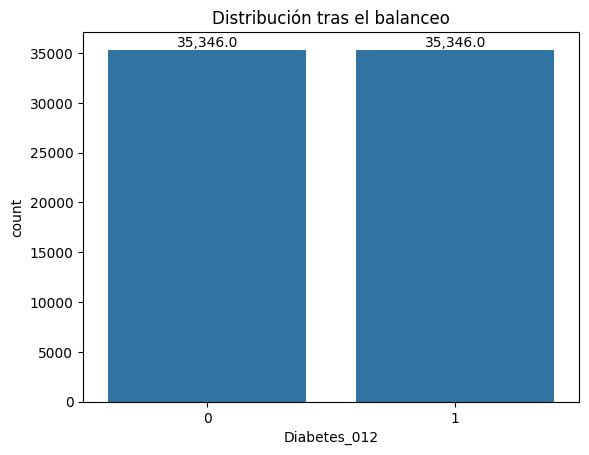

In [5]:
# Separar clases
df_majority = df[df[TARGET] == 0]
df_minority = df[df[TARGET] == 1]

# Reducción aleatoria de la clase mayoritaria al tamaño de la minoritaria
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),  # igualar tamaño
    random_state=42
)

# Combinar clases balanceadas
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Verificar distribución
print(df_balanced[TARGET].value_counts(normalize=True).rename({0: "No diabético", 1: "Diabético"}).map("{:.2%}".format))

# (Opcional) Nuevo gráfico
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.countplot(x=TARGET, data=df_balanced, ax=ax)
ax.set_title("Distribución tras el balanceo")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom")
plt.show()

## 2.4) Matriz de correlación

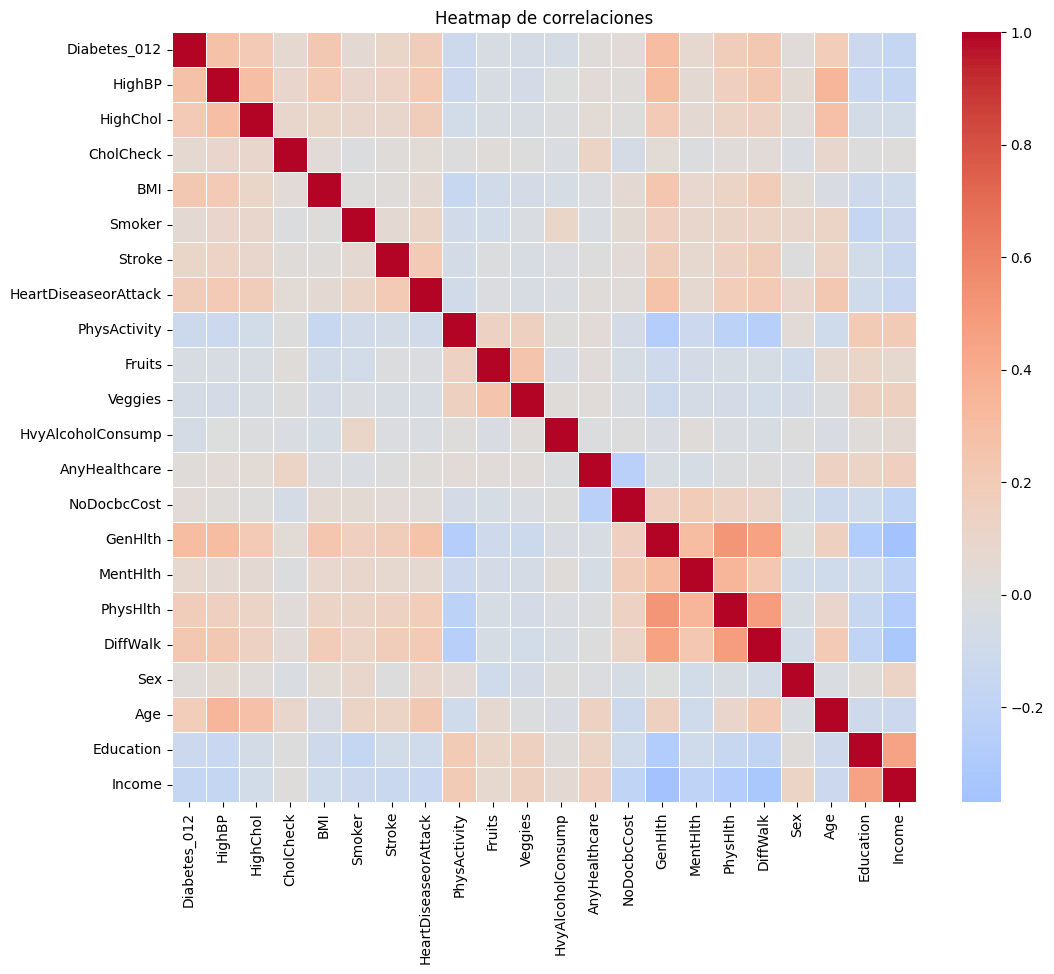

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0, linewidths=.5)
plt.title("Heatmap de correlaciones")
plt.show()


# 3) Preparación de datos

## 3.1) Balanceo de la variable objetivo

In [7]:
# Celda 7 bis  (inmediatamente después de la preparación de datos)
feature_cols = [c for c in df_balanced.columns if c != TARGET]
X, y = df_balanced[feature_cols].astype("float32"), df_balanced[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), feature_cols)],
    verbose_feature_names_out=False
)

# 1️⃣  Under-sampling sobre la clase mayoritaria
resampler = RandomUnderSampler(
    sampling_strategy="majority",  # reducir la clase mayoritaria
    random_state=RANDOM_STATE
)

# 2️⃣  Escalado
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), feature_cols)],
    verbose_feature_names_out=False
)

# 3️⃣  Clasificador
clf = LogisticRegression(
    solver="lbfgs",
    max_iter=200,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# 4️⃣  Pipeline
pipeline = ImbPipeline([
    ("resample", resampler),       # primero equilibramos
    ("prep", preprocessor),        # luego escalamos
    ("clf", clf),
])

Accuracy : 0.7480
F1-score : 0.7522

              precision    recall  f1-score   support

No diabético       0.76      0.73      0.74      7070
   Diabético       0.74      0.76      0.75      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



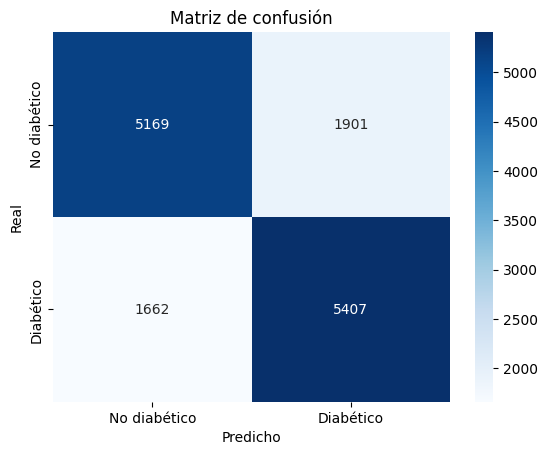

In [8]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)           # binaria ⇒ default = “binary”
print(f"Accuracy : {acc:.4f}")
print(f"F1-score : {f1:.4f}\n")
print(classification_report(y_test, y_pred,
                             target_names=["No diabético","Diabético"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No diabético","Diabético"],
            yticklabels=["No diabético","Diabético"])
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.title("Matriz de confusión")
plt.show()

In [9]:
# Celda 10
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    pipeline, X, y, cv=cv, scoring="f1_macro", n_jobs=-1
)
print("F1-macro CV (5 folds):", cv_scores.round(4))
print("Media ± desv.:", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


F1-macro CV (5 folds): [0.7446 0.7546 0.7489 0.7524 0.7498]
Media ± desv.: 0.7501 ± 0.0034


In [ ]:
# Métricas de calibración

def graficar_metricas(y_test, y_pred, y_proba):
    labels = ["No diabético", "Diabético"]

    # ── Matriz de Confusión ──
    cm = confusion_matrix(y_test, y_pred)
    fig_cm = go.Figure(data=go.Heatmap(
        z=cm,
        x=labels,
        y=labels,
        colorscale="Blues",
        showscale=True
    ))
    fig_cm.update_layout(
        title="Matriz de Confusión",
        xaxis_title="Predicho",
        yaxis_title="Real"
    )
    fig_cm.show()

    # ── Curva ROC ──
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    fig_roc = go.Figure()
    fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f"AUC = {auc:.3f}"))
    fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash')))
    fig_roc.update_layout(
        title="Curva ROC",
        xaxis_title="Tasa de Falsos Positivos (FPR)",
        yaxis_title="Tasa de Verdaderos Positivos (TPR)",
        showlegend=True
    )
    fig_roc.show()

    # ── Curva Precision-Recall ──
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    fig_pr = go.Figure()
    fig_pr.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name=f"AP = {ap:.3f}"))
    fig_pr.add_trace(go.Scatter(x=[0, 1], y=[1, 0], mode='lines', name='Referencia', line=dict(dash='dash')))
    fig_pr.update_layout(
        title="Curva Precision-Recall",
        xaxis_title="Recall",
        yaxis_title="Precision",
        showlegend=True
    )
    fig_pr.show()

In [12]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
graficar_metricas(y_test, y_pred, y_proba)

In [14]:
def plot_gain_lift_plotly(y_true, y_score):
    df_sort = pd.DataFrame({"y": y_true, "score": y_score}).sort_values("score", ascending=False)
    df_sort["cum_recall"] = df_sort["y"].cumsum() / df_sort["y"].sum()
    df_sort["perc_data"] = np.arange(1, len(df_sort) + 1) / len(df_sort)
    lift = df_sort["cum_recall"] / df_sort["perc_data"]

    fig_gain = go.Figure()
    fig_gain.add_trace(go.Scatter(x=df_sort["perc_data"], y=df_sort["cum_recall"], mode="lines", name="Gain"))
    fig_gain.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines", name="Aleatorio", line=dict(dash="dash")))
    fig_gain.update_layout(title="Curva Gain", xaxis_title="% datos ordenados por score", yaxis_title="% positivos capturados")

    fig_lift = go.Figure()
    fig_lift.add_trace(go.Scatter(x=df_sort["perc_data"], y=lift, mode="lines", name="Lift"))
    fig_lift.add_trace(go.Scatter(x=[0, 1], y=[1, 1], mode="lines", name="Base", line=dict(dash="dash")))
    fig_lift.update_layout(title="Curva Lift", xaxis_title="% datos", yaxis_title="Lift")

    return fig_gain, fig_lift

def plot_ks_curve_plotly(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    ks_stat = max(tpr - fpr)
    ks_thr = thr[np.argmax(tpr - fpr)]

    fig_ks = go.Figure()
    fig_ks.add_trace(go.Scatter(x=thr, y=tpr, mode='lines', name='TPR'))
    fig_ks.add_trace(go.Scatter(x=thr, y=fpr, mode='lines', name='FPR'))
    fig_ks.add_trace(go.Scatter(x=[ks_thr], y=[tpr[np.argmax(tpr - fpr)]], mode='markers+text',
                                text=[f"KS = {ks_stat:.3f}"], name='KS Point'))
    fig_ks.add_vline(x=ks_thr, line_dash="dash", line_color="black")
    fig_ks.update_layout(title="Curva KS", xaxis_title="Umbral", yaxis_title="Rate")
    return fig_ks

def plot_calibration_curve_plotly(y_true, y_score, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=n_bins)
    fig_calib = go.Figure()
    fig_calib.add_trace(go.Scatter(x=prob_pred, y=prob_true, mode='lines+markers', name='Calibración'))
    fig_calib.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Perfecto', line=dict(dash='dash')))
    fig_calib.update_layout(title="Curva de Calibración", xaxis_title="Probabilidad media predicha", yaxis_title="Frecuencia real")
    return fig_calib

# Simula valores (o reemplaza con los reales)
y_test = np.random.randint(0, 2, 1000)
y_proba = np.random.rand(1000)

# Mostrar
fig_gain, fig_lift = plot_gain_lift_plotly(y_test, y_proba)
fig_ks = plot_ks_curve_plotly(y_test, y_proba)
fig_calib = plot_calibration_curve_plotly(y_test, y_proba)

fig_gain.show()
fig_lift.show()
fig_ks.show()
fig_calib.show()
